# DBSCAN

In [101]:
import pandas as pd
import numpy as np
from math import pi
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import random
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import mapply
mapply.init(n_workers=7, progressbar=True)
import pickle
with open('scaler.pickle', 'rb') as f:
    scaler: StandardScaler = pickle.load(f)

In [120]:
def prepare(df, state, remove_outliers=True, with_indicators=True):
    cat_cols = ['date_month', 'date_day', 'date_year', 'congressional_district',
            'incident_characteristics1', 'city_or_county', 'party', 'CLEAN', 'OUTLIER']

    orig_num_cols = ['latitude', 'longitude', 'min_age_participants', 'avg_age_participants',
            'max_age_participants', 'n_participants_child', 'n_participants_teen',
            'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
            'n_arrested', 'n_unharmed', 'n_participants', 'timestamp',
            'povertyPercentage', 'candidatevotes', 'totalvotes']

    if 'latitude' not in df.columns:
        orig_num_cols = [s for s in orig_num_cols if s != 'latitude']
    if 'longitude' not in df.columns:
        orig_num_cols = [s for s in orig_num_cols if s != 'longitude']

    if remove_outliers:
        df = df[df['OUTLIER'] == 0]
    
    df = df[df['state'] == state]

    df.loc[:, cat_cols] = df.loc[:, cat_cols].astype('object')#df[cat_cols] = df[cat_cols].astype('object')
    numerical_df = df.select_dtypes(include=['int64', 'float64'])

    if not with_indicators:
        numerical_df = numerical_df[orig_num_cols]

    scaler = StandardScaler()
    numerical_scaled = scaler.fit_transform(numerical_df)
    numerical_scaled = pd.DataFrame(numerical_scaled, columns=numerical_df.columns)

    return numerical_df, numerical_scaled, scaler


def features_reduction_corr(df, correlation_threshold=0.7):
    # Compute the correlation matrix
    correlation_matrix = df.corr()

    # Identify highly correlated features
    highly_correlated_features = set()

    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
                colname = correlation_matrix.columns[i]
                highly_correlated_features.add(colname)

    # Remove highly correlated features
    df_filtered = df.drop(columns=highly_correlated_features)
    return df_filtered


def features_reduction_var(df, variance_threshold=2):
    # Compute the variance of each feature
    feature_variances = df.var()

    # Identify features below the variance threshold
    low_variance_features = feature_variances[feature_variances < variance_threshold].index

    # Prune (remove) features below the threshold
    df_pruned = df.drop(columns=low_variance_features)

    return df_pruned


def k_means(df, k_min, k_max, initial_centroids=None, max_iter=300):
    models = []
    for i in range(k_min):
        models.append(None)

    for k in tqdm(range(k_min, k_max+1)):
        if initial_centroids is None:
            model = KMeans(n_clusters=k, n_init=10, max_iter=max_iter)
        else:
            model = KMeans(n_clusters=k, n_init=10, max_iter=max_iter, init=initial_centroids)
        model.fit(df)
        models.append(model)

    return models


def scores(models, df, k_min, k_max, sample_size=-1, n_samples=1):
    SSEs = []
    separations = []
    silhouettess = []

    for i in range(0, k_min):
        SSEs.append(None)
        separations.append(None)
        silhouettess.append([])
    
    models = models[k_min:k_max+1]

    k = k_min

    for model in models:

        print(f'k = {k}')

        SSEs.append(model.inertia_)
        separations.append(metrics.davies_bouldin_score(df, model.labels_))

        silhouettes = []
        for j in tqdm(range(0, n_samples)):
            if sample_size == -1:
                sample_size = df.shape[0]   
            sampled_indeces = random.sample(range(df.shape[0]), sample_size)
            sampled_points = [df.iloc[i] for i in sampled_indeces]
            sampled_labels = [model.labels_[i] for i in sampled_indeces]
            silhouettes.append(silhouette_score(sampled_points, sampled_labels))
        silhouettess.append(silhouettes)

        k += 1
    
    scoress_dict = {
        'SSE': SSEs,
        'Separation': separations,
        'Silhouette': silhouettess
    }

    return scoress_dict


def perform_PCA(df, centroids=None, n_components=2):
    pca = PCA(n_components=n_components)

    points_pca = pca.fit_transform(df)
    if centroids is not None:
        centroids_pca = pca.transform(centroids)
        return points_pca, centroids_pca
    return points_pca


def find_features(df, columns, col_scores, threshold=0.1):
    prev_max_score = max(col_scores)
    actual_cols = [columns.pop(0)]
    
    for col in columns:
        actual_cols.append(col)
        scores, _, _ = k_means(df=df[actual_cols], n_samples=1, sample_size=10000, k_min=2, k_max=10)
        max_score = max(scores)
        if np.abs(prev_max_score - max_score) > 0.1:#prev_max_score > max_score:
            actual_cols.pop()
            print(col + ' discarded')
            print('actual score: ' + str(max_score))
        else:
            if prev_max_score < max_score:
                prev_max_score = max_score
            print(col + ' added')
            print('actual score: ' + str(max_score))
    return actual_cols, prev_max_score


def order_features(df):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_df = df[numeric_cols]
    columns = numeric_df.columns.tolist()
    #random.shuffle(columns)

    max_scores = []
    for col in columns:
        scores, _, _ = k_means(df=df[[col]], n_samples=1, sample_size=10000, k_min=2, k_max=9)
        max_scores.append(max(scores))

    combined = list(zip(columns, max_scores))
    sorted_combined = sorted(combined, key=lambda x: x[1], reverse=True)
    sorted_cols = [item for item, score in sorted_combined]
    sorted_scores = [score for item, score in sorted_combined]

    return sorted_cols, sorted_scores


def sample_columns(df, num_columns_to_sample=1):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_df = df[numeric_cols]
    df_reduced = numeric_df.sample(n=num_columns_to_sample, axis=1).copy()
    return df_reduced


def show_scores(scores_dict, k_min, k_max):
    k_values = np.arange(k_min, k_max+1)
    fig, axes = plt.subplots(nrows=1, ncols=len(scores_dict), figsize=(15, 3))

    axes[0].plot(k_values, scores_dict['SSE'][k_min:k_max+1])
    axes[0].set_title('SSE')
    axes[0].set_xlabel('Number of clusters')
    axes[0].set_ylabel('SSE')

    axes[1].plot(k_values, scores_dict['Separation'][k_min:k_max+1])
    axes[1].set_title('Separation')
    axes[1].set_xlabel('Number of clusters')
    axes[1].set_ylabel('Separation')

    mean_scores = []
    silhouettess = scores_dict['Silhouette']
    for k in k_values:
        mean_scores.append(np.mean(np.array(silhouettess[k])))
        
    axes[2].plot(k_values, mean_scores)
    axes[2].set_title('Silhouette')
    axes[2].set_xlabel('Number of clusters')
    axes[2].set_ylabel('Silhouette')

    plt.tight_layout()
    plt.show()

    return mean_scores


def find_elbow(dist_matrix):
    distortions = []

    # Calculate distortion for each k
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(df_orig_s)
        distortion = sum(np.min(dist_matrix, axis=1)) / df_orig_s.shape[0]
        distortions.append(distortion)

    # Calculate the angles between successive line segments
    angles = [np.arctan2(distortions[i] - distortions[i - 1], 1) for i in range(1, len(distortions))]

    # Find the index of the maximum angle (elbow point)
    elbow_index = np.argmax(angles) + 1  # Adding 1 to align with the original indices

    return elbow_index


Dataset dimentions: (235219, 61)
Dataset dimentions without ouliers, with only numerical cols, without indicators: (5020, 19)
Dataset dimentions without ouliers, with only numerical cols, with indicators: (5020, 51)


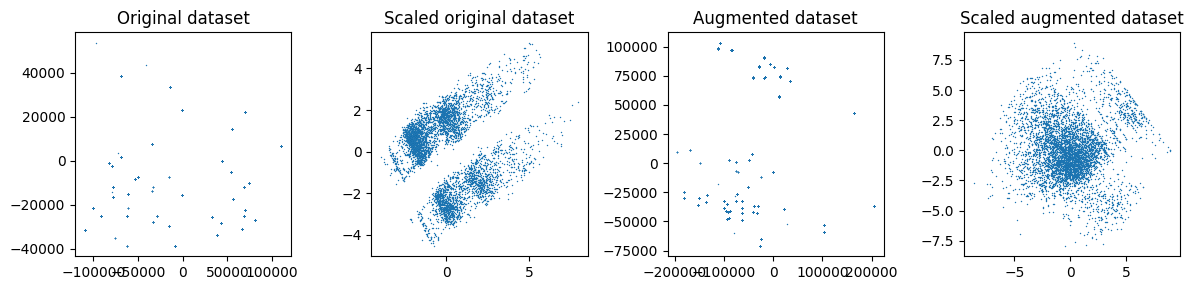

In [29]:
df_init = pd.read_csv('./dataset/data/final_clean2.csv')

df_orig, df_orig_s, scaler_orig = prepare(df=df_init, state='MICHIGAN', remove_outliers=True, with_indicators=False)
df, df_s, scaler = prepare(df=df_init, state='MICHIGAN', remove_outliers=True, with_indicators=True)



print(f'Dataset dimentions: {df_init.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, without indicators: {df_orig.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, with indicators: {df.shape}')

pca_orig = perform_PCA(df=df_orig, n_components=2)
pca_orig_s = perform_PCA(df=df_orig_s, n_components=2)

pca = perform_PCA(df=df, n_components=2)
pca_s = perform_PCA(df=df_s, n_components=2)

plt.figure(figsize=(12, 3))

plt.subplot(1, 4, 1)
plt.scatter(pca_orig[:, 0], pca_orig[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Original dataset')

plt.subplot(1, 4, 2)
plt.scatter(pca_orig_s[:, 0], pca_orig_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Scaled original dataset')

plt.subplot(1, 4, 3)
plt.scatter(pca[:, 0], pca[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Augmented dataset')

plt.subplot(1, 4, 4)
plt.scatter(pca_s[:, 0], pca_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Scaled augmented dataset')

plt.tight_layout()
plt.show()

Dataset dimentions: (235219, 61)
Dataset dimentions without ouliers, with only numerical cols, without indicators: (16419, 19)
Dataset dimentions without ouliers, with only numerical cols, with indicators: (16419, 51)


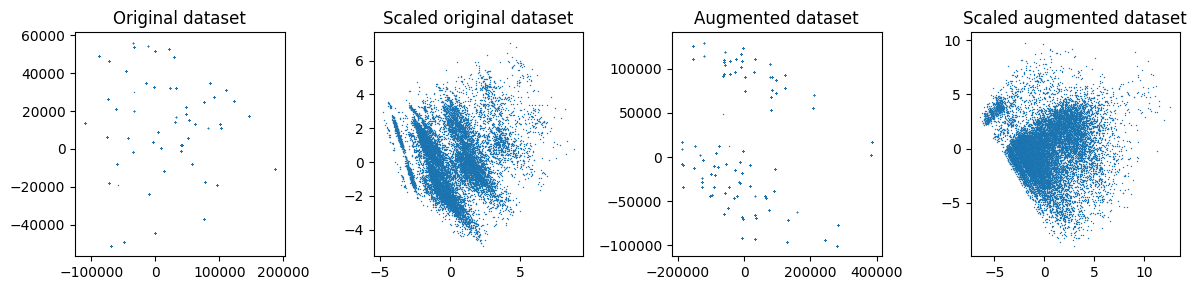

In [13]:
df_init = pd.read_csv('./dataset/data/final_clean2.csv')

df_orig, df_orig_s, scaler_orig = prepare(df=df_init, state='ILLINOIS', remove_outliers=True, with_indicators=False)
df, df_s, scaler = prepare(df=df_init, state='ILLINOIS', remove_outliers=True, with_indicators=True)



print(f'Dataset dimentions: {df_init.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, without indicators: {df_orig.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, with indicators: {df.shape}')

pca_orig = perform_PCA(df=df_orig, n_components=2)
pca_orig_s = perform_PCA(df=df_orig_s, n_components=2)

pca = perform_PCA(df=df, n_components=2)
pca_s = perform_PCA(df=df_s, n_components=2)

plt.figure(figsize=(12, 3))

plt.subplot(1, 4, 1)
plt.scatter(pca_orig[:, 0], pca_orig[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Original dataset')

plt.subplot(1, 4, 2)
plt.scatter(pca_orig_s[:, 0], pca_orig_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Scaled original dataset')

plt.subplot(1, 4, 3)
plt.scatter(pca[:, 0], pca[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Augmented dataset')

plt.subplot(1, 4, 4)
plt.scatter(pca_s[:, 0], pca_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Scaled augmented dataset')

plt.tight_layout()
plt.show()

Dataset dimentions: (235219, 61)
Dataset dimentions without ouliers, with only numerical cols, without indicators: (8630, 19)
Dataset dimentions without ouliers, with only numerical cols, with indicators: (8630, 51)


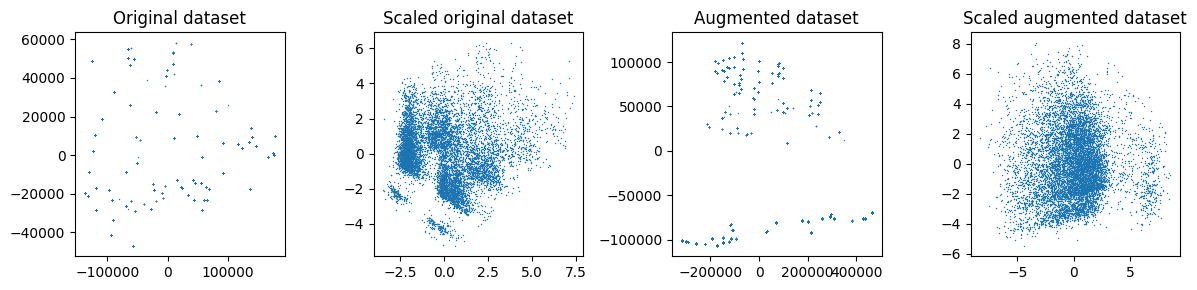

In [14]:
df_init = pd.read_csv('./dataset/data/final_clean2.csv')

df_orig, df_orig_s, scaler_orig = prepare(df=df_init, state='NEW YORK', remove_outliers=True, with_indicators=False)
df, df_s, scaler = prepare(df=df_init, state='NEW YORK', remove_outliers=True, with_indicators=True)



print(f'Dataset dimentions: {df_init.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, without indicators: {df_orig.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, with indicators: {df.shape}')

pca_orig = perform_PCA(df=df_orig, n_components=2)
pca_orig_s = perform_PCA(df=df_orig_s, n_components=2)

pca = perform_PCA(df=df, n_components=2)
pca_s = perform_PCA(df=df_s, n_components=2)

plt.figure(figsize=(12, 3))

plt.subplot(1, 4, 1)
plt.scatter(pca_orig[:, 0], pca_orig[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Original dataset')

plt.subplot(1, 4, 2)
plt.scatter(pca_orig_s[:, 0], pca_orig_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Scaled original dataset')

plt.subplot(1, 4, 3)
plt.scatter(pca[:, 0], pca[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Augmented dataset')

plt.subplot(1, 4, 4)
plt.scatter(pca_s[:, 0], pca_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Scaled augmented dataset')

plt.tight_layout()
plt.show()

Dataset dimentions: (235219, 61)
Dataset dimentions without ouliers, with only numerical cols, without indicators: (7174, 19)
Dataset dimentions without ouliers, with only numerical cols, with indicators: (7174, 51)


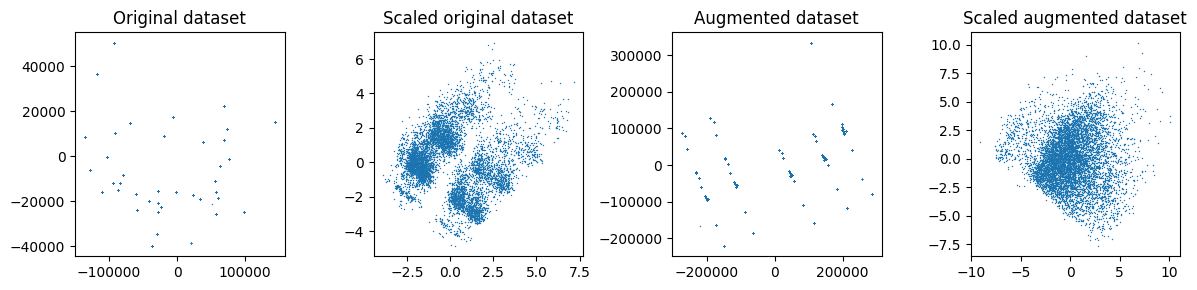

In [30]:
df_init = pd.read_csv('./dataset/data/final_clean2.csv')

df_orig, df_orig_s, scaler_orig = prepare(df=df_init, state='NORTH CAROLINA', remove_outliers=True, with_indicators=False)
df, df_s, scaler = prepare(df=df_init, state='NORTH CAROLINA', remove_outliers=True, with_indicators=True)



print(f'Dataset dimentions: {df_init.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, without indicators: {df_orig.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, with indicators: {df.shape}')

pca_orig = perform_PCA(df=df_orig, n_components=2)
pca_orig_s = perform_PCA(df=df_orig_s, n_components=2)

pca = perform_PCA(df=df, n_components=2)
pca_s = perform_PCA(df=df_s, n_components=2)

plt.figure(figsize=(12, 3))

plt.subplot(1, 4, 1)
plt.scatter(pca_orig[:, 0], pca_orig[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Original dataset')

plt.subplot(1, 4, 2)
plt.scatter(pca_orig_s[:, 0], pca_orig_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Scaled original dataset')

plt.subplot(1, 4, 3)
plt.scatter(pca[:, 0], pca[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Augmented dataset')

plt.subplot(1, 4, 4)
plt.scatter(pca_s[:, 0], pca_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Scaled augmented dataset')

plt.tight_layout()
plt.show()

Dataset dimentions: (235219, 61)
Dataset dimentions without ouliers, with only numerical cols, without indicators: (7650, 19)
Dataset dimentions without ouliers, with only numerical cols, with indicators: (7650, 51)


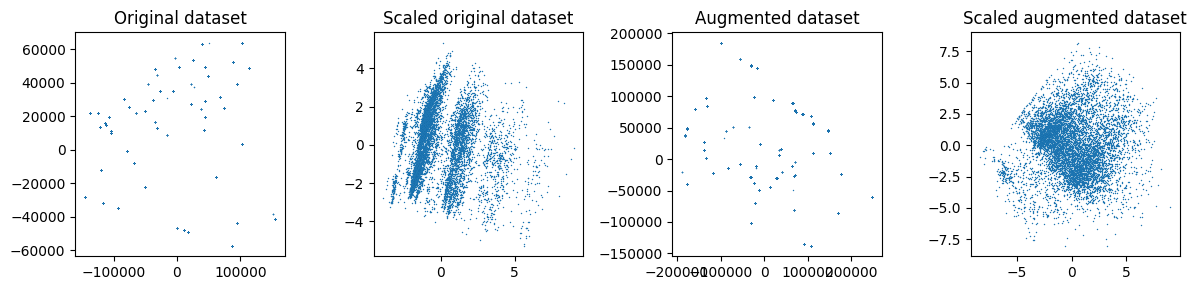

In [105]:
df_init = pd.read_csv('./dataset/data/final_clean2.csv')

df_orig, df_orig_s, scaler_orig = prepare(df=df_init, state='PENNSYLVANIA', remove_outliers=True, with_indicators=False)
df, df_s, scaler = prepare(df=df_init, state='PENNSYLVANIA', remove_outliers=True, with_indicators=True)



print(f'Dataset dimentions: {df_init.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, without indicators: {df_orig.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, with indicators: {df.shape}')

pca_orig = perform_PCA(df=df_orig, n_components=2)
pca_orig_s = perform_PCA(df=df_orig_s, n_components=2)

pca = perform_PCA(df=df, n_components=2)
pca_s = perform_PCA(df=df_s, n_components=2)

plt.figure(figsize=(12, 3))

plt.subplot(1, 4, 1)
plt.scatter(pca_orig[:, 0], pca_orig[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Original dataset')

plt.subplot(1, 4, 2)
plt.scatter(pca_orig_s[:, 0], pca_orig_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Scaled original dataset')

plt.subplot(1, 4, 3)
plt.scatter(pca[:, 0], pca[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Augmented dataset')

plt.subplot(1, 4, 4)
plt.scatter(pca_s[:, 0], pca_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Scaled augmented dataset')

plt.tight_layout()
plt.show()

Initial n_cols = 19

Survived columns (variance_threshold = 1):----------------------------------------------
n_cols = 18
Index(['latitude', 'longitude', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_participants_teen', 'n_participants_adult',
       'n_males', 'n_females', 'n_killed', 'n_injured', 'n_arrested',
       'n_unharmed', 'n_participants', 'timestamp', 'povertyPercentage',
       'candidatevotes', 'totalvotes'],
      dtype='object')

Survived columns (correlation_threshold = 0.25):----------------------------------------------
n_cols = 4
Index(['latitude', 'min_age_participants', 'n_killed', 'timestamp'], dtype='object')


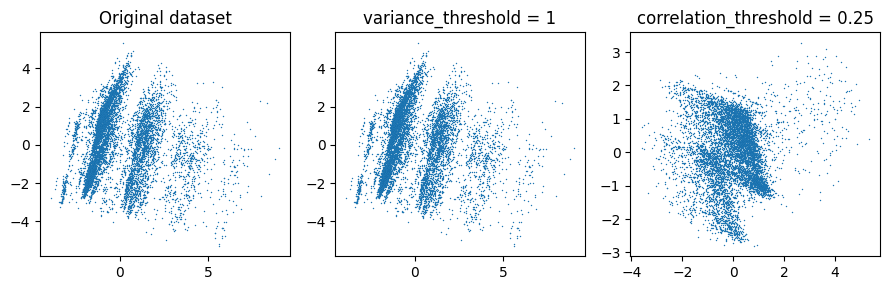

In [106]:
var_thr = 1
reduced_orig_var = features_reduction_var(df_orig_s, variance_threshold=var_thr)
print(f'Initial n_cols = {df_orig_s.shape[1]}')
print(f'\nSurvived columns (variance_threshold = {var_thr}):----------------------------------------------')
print(f'n_cols = {len(reduced_orig_var.columns)}')
print(reduced_orig_var.columns)

corr_thr = 0.25
reduced_orig = features_reduction_corr(reduced_orig_var, correlation_threshold=corr_thr)
print(f'\nSurvived columns (correlation_threshold = {corr_thr}):----------------------------------------------')
print(f'n_cols = {len(reduced_orig.columns)}')
print(reduced_orig.columns)

pca_orig_v = perform_PCA(df=reduced_orig_var, n_components=2)
pca_orig_c = perform_PCA(df=reduced_orig, n_components=2)

plt.figure(figsize=(9, 3))

plt.subplot(1, 3, 1)
plt.scatter(pca_orig_s[:, 0], pca_orig_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Original dataset')

plt.subplot(1, 3, 2)
plt.scatter(pca_orig_v[:, 0], pca_orig_v[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title(f'variance_threshold = {var_thr}')

plt.subplot(1, 3, 3)
plt.scatter(pca_orig_c[:, 0], pca_orig_c[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title(f'correlation_threshold = {corr_thr}')

plt.tight_layout()
plt.show()

Initial n_cols = 51

Survived columns (variance_threshold = 1):----------------------------------------------
n_cols = 48
Index(['latitude', 'longitude', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_participants_teen', 'n_participants_adult',
       'n_males', 'n_females', 'n_killed', 'n_injured', 'n_arrested',
       'n_unharmed', 'n_participants', 'timestamp', 'povertyPercentage',
       'candidatevotes', 'totalvotes', 'state_population', 'p_males',
       'p_females', 'p_participants_teen', 'p_participants_adult', 'p_killed',
       'p_injured', 'p_arrested', 'p_unharmed',
       'month_cd_change_min_age_participants',
       'month_cd_change_avg_age_participants',
       'month_cd_change_max_age_participants', 'month_cd_ratio_males',
       'month_cd_ratio_females', 'month_cd_ratio_participants_teen',
       'month_cd_ratio_participants_adult', 'month_cd_ratio_killed',
       'month_cd_ratio_injured', 'month_cd_ratio_arrested',
       'month_cd_

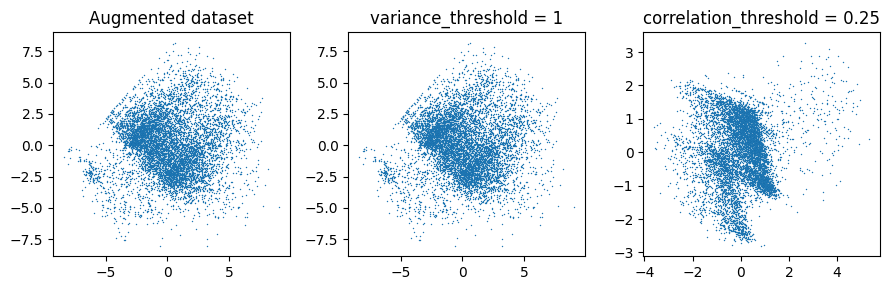

In [107]:
var_thr = 1
reduced_var = features_reduction_var(df_s, variance_threshold=var_thr)
print(f'Initial n_cols = {df_s.shape[1]}')
print(f'\nSurvived columns (variance_threshold = {var_thr}):----------------------------------------------')
print(f'n_cols = {len(reduced_var.columns)}')
print(reduced_var.columns)

corr_thr = 0.25
reduced = features_reduction_corr(reduced_var, correlation_threshold=corr_thr)
print(f'\nSurvived columns (correlation_threshold = {corr_thr}):----------------------------------------------')
print(f'n_cols = {len(reduced.columns)}')
print(reduced.columns)

pca_v = perform_PCA(df=reduced_var, n_components=2)
pca_c = perform_PCA(df=reduced, n_components=2)

plt.figure(figsize=(9, 3))

plt.subplot(1, 3, 1)
plt.scatter(pca_s[:, 0], pca_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Augmented dataset')

plt.subplot(1, 3, 2)
plt.scatter(pca_v[:, 0], pca_v[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title(f'variance_threshold = {var_thr}')

plt.subplot(1, 3, 3)
plt.scatter(pca_c[:, 0], pca_c[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title(f'correlation_threshold = {corr_thr}')

plt.tight_layout()
plt.show()

Knee Method to estimate the best eps

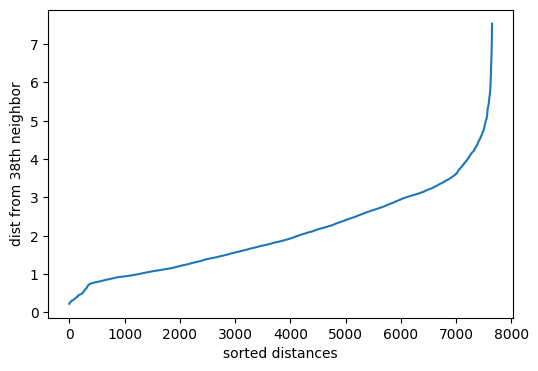

In [135]:
k = 38

dist = pdist(df_orig_s, 'euclidean')
dist = squareform(dist)

kth_distances = list()
for d in dist:
    index_kth_distance = np.argsort(d)[k]
    kth_distances.append(d[index_kth_distance])

kth_dist_mean = np.mean(kth_distances)
if kth_dist_mean > 5:
    to_check = np.arange(kth_dist_mean-5, kth_dist_mean+5.5, 0.5)
else:
    to_check = np.arange(0.1, kth_dist_mean+5.5, 0.5)

plt.figure(figsize=(6, 4))
plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.ylabel(f'dist from {k}th neighbor', fontsize=10)
plt.xlabel('sorted distances', fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

models_orig = []
for eps in to_check:
    dbscan = DBSCAN(eps=eps, min_samples=k)
    dbscan.fit(df_orig_s)
    models_orig.append(dbscan)

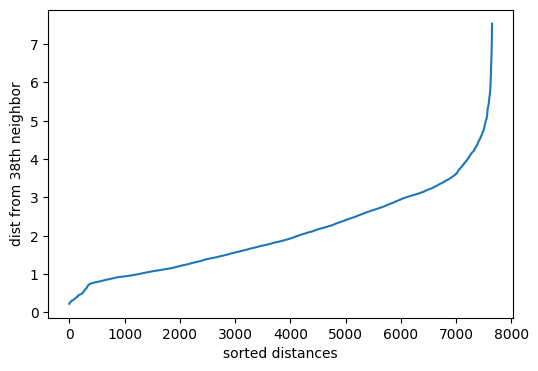

In [204]:
k = 38

dist = pdist(df_orig_s, 'euclidean')
dist = squareform(dist)

kth_distances = list()
for d in dist:
    index_kth_distance = np.argsort(d)[k]
    kth_distances.append(d[index_kth_distance])
kth_distances_df = pd.DataFrame(kth_distances)
kth_distances_df = kth_distances_df.rolling(window=1).mean()
kth_distancess = kth_distances_df.values.tolist()
sorted_kth_distances = sorted(kth_distancess)

plt.figure(figsize=(6, 4))
plt.plot(range(0, len(kth_distancess)), sorted_kth_distances)
plt.ylabel(f'dist from {k}th neighbor', fontsize=10)
plt.xlabel('sorted distances', fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

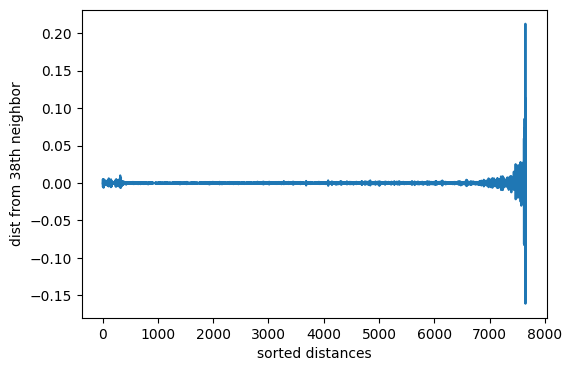

-0.0006092171781220124


In [209]:
sorted_kth_distances_ = [x[0] for x in sorted_kth_distances[2:]]
secnd_grad = np.diff(sorted_kth_distances_, n=2)

plt.figure(figsize=(6, 4))
plt.plot(range(4, len(kth_distancess)), secnd_grad)
plt.ylabel(f'dist from {k}th neighbor', fontsize=10)
plt.xlabel('sorted distances', fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

print(secnd_grad[5500])

In [141]:
for m, eps in zip(models_orig, to_check):
    print(f'eps = {eps}-----------------')
    cluster_labels, cluster_counts = np.unique(m.labels_, return_counts=True)
    for l, c in zip(cluster_labels, cluster_counts):
        print(f'Cluster {l}: {c} points')
    if len(cluster_labels) > 1:
        print(f'Silhouette {silhouette_score(df_orig_s, m.labels_)}')

eps = 0.1-----------------
Cluster -1: 7650 points
eps = 0.6-----------------
Cluster -1: 7291 points
Cluster 0: 172 points
Cluster 1: 187 points
Silhouette -0.13254024384699664
eps = 1.1-----------------
Cluster -1: 5106 points
Cluster 0: 270 points
Cluster 1: 751 points
Cluster 2: 73 points
Cluster 3: 49 points
Cluster 4: 146 points
Cluster 5: 191 points
Cluster 6: 52 points
Cluster 7: 188 points
Cluster 8: 40 points
Cluster 9: 41 points
Cluster 10: 109 points
Cluster 11: 51 points
Cluster 12: 309 points
Cluster 13: 274 points
Silhouette -0.10243643966935015
eps = 1.6-----------------
Cluster -1: 3374 points
Cluster 0: 490 points
Cluster 1: 1132 points
Cluster 2: 78 points
Cluster 3: 146 points
Cluster 4: 100 points
Cluster 5: 68 points
Cluster 6: 468 points
Cluster 7: 81 points
Cluster 8: 63 points
Cluster 9: 59 points
Cluster 10: 38 points
Cluster 11: 43 points
Cluster 12: 80 points
Cluster 13: 90 points
Cluster 14: 44 points
Cluster 15: 403 points
Cluster 16: 415 points
Cluster 17

Cluster -1: 583 points
Cluster 0: 5960 points
Cluster 1: 388 points
Cluster 2: 719 points
Silhouette 0.1585058210115701


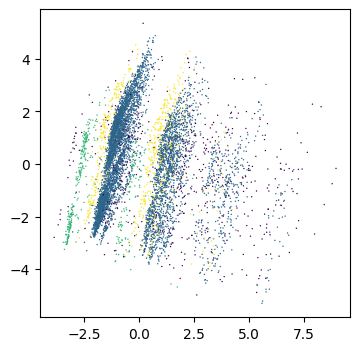

In [124]:
points_pca = perform_PCA(df=df_orig_s, n_components=2)

plt.figure(figsize=(4, 4))
plt.scatter(points_pca[:, 0], points_pca[:, 1], c=m.labels_, s=1, edgecolors='black', linewidths=0.001)

cluster_labels, cluster_counts = np.unique(m.labels_, return_counts=True)
for l, c in zip(cluster_labels, cluster_counts):
    print(f'Cluster {l}: {c} points')

print(f'Silhouette {silhouette_score(df_orig_s, m.labels_)}')

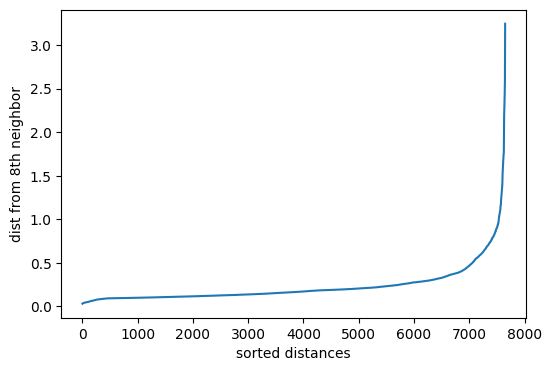

In [98]:
k = 8

dist = pdist(reduced_orig, 'euclidean') #pair wise distance
dist = squareform(dist) #distance matrix given the vector dist

kth_distances = list()
for d in dist:
    index_kth_distance = np.argsort(d)[k]
    kth_distances.append(d[index_kth_distance])

plt.figure(figsize=(6, 4))
plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.ylabel(f'dist from {k}th neighbor', fontsize=10)
plt.xlabel('sorted distances', fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

Cluster -1: 366 points
Cluster 0: 1741 points
Cluster 1: 5509 points
Cluster 2: 19 points
Cluster 3: 8 points
Cluster 4: 7 points
Silhouette 0.3564491062387631


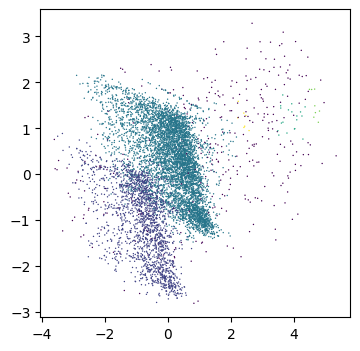

In [100]:
dbscan_orig_r = DBSCAN(eps=0.5, min_samples=k)
dbscan_orig_r.fit(reduced_orig)

points_pca = perform_PCA(df=reduced_orig, n_components=2)

plt.figure(figsize=(4, 4))
plt.scatter(points_pca[:, 0], points_pca[:, 1], c=dbscan_orig_r.labels_, s=1, edgecolors='black', linewidths=0.001)

cluster_labels, cluster_counts = np.unique(dbscan_orig_r.labels_, return_counts=True)
for l, c in zip(cluster_labels, cluster_counts):
    print(f'Cluster {l}: {c} points')

print(f'Silhouette {silhouette_score(reduced_orig, dbscan_orig_r.labels_)}')